**Run the demo.** Run the following cells to synthesize example image pairs from a prompt of your choice and our predicted semantic correspondences.

In [2]:
%load_ext autoreload
%autoreload 2
from archs.stable_diffusion.diffusion import latent_to_image
from archs.stable_diffusion.resnet import collect_dims
from archs.correspondence_utils import (
  batch_cosine_sim,
  rescale_points,
  find_nn_correspondences,
  draw_correspondences,
  points_to_patches,
  compute_pck
)
import os
import random
import torch
import math
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from extract_hyperfeatures import load_models

from diffusers import DDIMScheduler
from archs.stable_diffusion.diffusion import (
    init_models, 
    get_tokens_embedding,
    generalized_steps,
    collect_and_resize_feats
)
from torch import nn
from archs.detectron2.resnet import ResNet, BottleneckBlock
from archs.stable_diffusion.resnet import init_resnet_func

In [63]:
class DiffusionExtractor:
    """
    Module for running either the generation or inversion process 
    and extracting intermediate feature maps.
    """
    def __init__(self, config, device):
        self.device = device
        self.scheduler = DDIMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            num_train_timesteps=1000,
        )
        self.num_timesteps = config["num_timesteps"]
        self.scheduler.set_timesteps(self.num_timesteps)
        self.generator = torch.Generator(self.device).manual_seed(config.get("seed", 0))
        self.batch_size = config.get("batch_size", 1)

        self.unet, self.vae, self.clip, self.clip_tokenizer = init_models(device=self.device, model_id=config["model_id"])
        self.prompt = config.get("prompt", "")
        self.negative_prompt = config.get("negative_prompt", "")
        self.change_cond(self.prompt, "cond")
        self.change_cond(self.negative_prompt, "uncond")
        
        self.diffusion_mode = config.get("diffusion_mode", "generation")
        if "idxs" in config and config["idxs"] is not None:
            self.idxs = config["idxs"]
        else:
            self.idxs = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
        self.output_resolution = config["output_resolution"]

        # Note that save_timestep is in terms of number of generation steps
        # save_timestep = 0 is noise, save_timestep = T is a clean image
        # generation saves as [0...T], inversion saves as [T...0]
        self.save_timestep = config.get("save_timestep", [])

        print(f"diffusion_mode: {self.diffusion_mode}")
        print(f"idxs: {self.idxs}")
        print(f"output_resolution: {self.output_resolution}")
        print(f"prompt: {self.prompt}")
        print(f"negative_prompt: {self.negative_prompt}")

    def change_cond(self, prompt, cond_type="cond"):
        with torch.no_grad():
            with torch.autocast("cuda"):
                _, new_cond = get_tokens_embedding(self.clip_tokenizer, self.clip, self.device, prompt)
                new_cond = new_cond.expand((self.batch_size, *new_cond.shape[1:]))
                new_cond = new_cond.to(self.device)
                if cond_type == "cond":
                    self.cond = new_cond
                    self.prompt = prompt
                elif cond_type == "uncond":
                    self.uncond = new_cond
                    self.negative_prompt = prompt
                else:
                    raise NotImplementedError

    def run_generation(self, latent, guidance_scale=-1, min_i=None, max_i=None):
        xs = generalized_steps(
            latent,
            self.unet, 
            self.scheduler, 
            run_inversion=False, 
            guidance_scale=guidance_scale, 
            conditional=self.cond, 
            unconditional=self.uncond, 
            min_i=min_i,
            max_i=max_i
        )
        return xs
    
    def run_inversion(self, latent, guidance_scale=-1, min_i=None, max_i=None):
        xs = generalized_steps(
            latent, 
            self.unet, 
            self.scheduler, 
            run_inversion=True, 
            guidance_scale=guidance_scale, 
            conditional=self.cond, 
            unconditional=self.uncond,
            min_i=min_i,
            max_i=max_i
        )
        return xs

    def get_feats(self, latents, extractor_fn, preview_mode=False):
        # returns feats of shape [batch_size, num_timesteps, channels, w, h]
        if not preview_mode:
            init_resnet_func(self.unet, save_hidden=True, reset=True, idxs=self.idxs, save_timestep=self.save_timestep)
        outputs = extractor_fn(latents)
        if not preview_mode:
            feats = []
            for timestep in self.save_timestep:
                timestep_feats = collect_and_resize_feats(self.unet, self.idxs, timestep, self.output_resolution)
                feats.append(timestep_feats)
            feats = torch.stack(feats, dim=1)
            init_resnet_func(self.unet, reset=True)
        else:
            feats = None
        return feats, outputs

    def latents_to_images(self, latents):
        latents = latents.to(self.device)
        latents = latents / 0.18215
        images = self.vae.decode(latents.to(self.vae.dtype)).sample
        images = (images / 2 + 0.5).clamp(0, 1)
        images = images.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (images * 255).round().astype("uint8")
        return [Image.fromarray(image) for image in images]

    def forward(self, images=None, latents=None, guidance_scale=-1, preview_mode=False):
        if images is None:
            if latents is None:
                latents = torch.randn((self.batch_size, self.unet.in_channels, 512 // 8, 512 // 8), device=self.device, generator=self.generator)
                print("latents:", latents)
            if self.diffusion_mode == "generation":
                if preview_mode:
                    extractor_fn = lambda latents: self.run_generation(latents, guidance_scale, max_i=self.end_timestep)
                else:
                    extractor_fn = lambda latents: self.run_generation(latents, guidance_scale)
            elif self.diffusion_mode == "inversion":
                raise NotImplementedError
        else:
            images = torch.nn.functional.interpolate(images, size=512, mode="bilinear")
            latents = self.vae.encode(images).latent_dist.sample(generator=None) * 0.18215
            if self.diffusion_mode == "inversion":
                extractor_fn = lambda latents: self.run_inversion(latents, guidance_scale)
            elif self.diffusion_mode == "generation":
                raise NotImplementedError
        
        with torch.no_grad():
            with torch.autocast("cuda"):
                return self.get_feats(latents, extractor_fn, preview_mode=preview_mode)

In [4]:
class AggregationNetwork(nn.Module):
    """
    Module for aggregating feature maps across time and space.
    Design inspired by the Feature Extractor from ODISE (Xu et. al., CVPR 2023).
    https://github.com/NVlabs/ODISE/blob/5836c0adfcd8d7fd1f8016ff5604d4a31dd3b145/odise/modeling/backbone/feature_extractor.py
    """
    def __init__(
            self, 
            feature_dims, 
            device, 
            projection_dim=384, 
            num_norm_groups=32,
            num_res_blocks=1, 
            save_timestep=[],
            num_timesteps=None,
            timestep_weight_sharing=False
        ):
        super().__init__()
        self.bottleneck_layers = nn.ModuleList()
        self.feature_dims = feature_dims    
        # For CLIP symmetric cross entropy loss during training
        self.logit_scale = torch.ones([]) * np.log(1 / 0.07)
        self.device = device
        self.save_timestep = save_timestep

        self.mixing_weights_names = []
        for l, feature_dim in enumerate(self.feature_dims):
            bottleneck_layer = nn.Sequential(
                *ResNet.make_stage(
                    BottleneckBlock,
                    num_blocks=num_res_blocks,
                    in_channels=feature_dim,
                    bottleneck_channels=projection_dim // 4,
                    out_channels=projection_dim,
                    norm="GN",
                    num_norm_groups=num_norm_groups
                )
            )
            self.bottleneck_layers.append(bottleneck_layer)
            for t in save_timestep:
                # 1-index the layer name following prior work
                self.mixing_weights_names.append(f"timestep-{save_timestep}_layer-{l+1}")
        
        self.bottleneck_layers = self.bottleneck_layers.to(device)
        mixing_weights = torch.ones(len(self.bottleneck_layers) * len(save_timestep))
        self.mixing_weights = nn.Parameter(mixing_weights.to(device))

    def forward(self, batch):
        """
        Assumes batch is shape (B, C, H, W) where C is the concatentation of all layer features.
        """
        output_feature = None
        start = 0
        mixing_weights = torch.nn.functional.softmax(self.mixing_weights)
        print("length of mixing weights:", len(mixing_weights))
        for i in range(len(mixing_weights)):
            # Share bottleneck layers across timesteps
            bottleneck_layer = self.bottleneck_layers[i % len(self.feature_dims)]
            # Chunk the batch according the layer
            # Account for looping if there are multiple timesteps
            end = start + self.feature_dims[i % len(self.feature_dims)]
            feats = batch[:, start:end, :, :]
            start = end
            # Downsample the number of channels and weight the layer
            bottlenecked_feature = bottleneck_layer(feats)
            bottlenecked_feature = mixing_weights[i] * bottlenecked_feature
            if output_feature is None:
                output_feature = bottlenecked_feature
            else:
                output_feature += bottlenecked_feature
        return output_feature

In [5]:
def load_models(config_path, device="cuda"):
    config = OmegaConf.load(config_path)
    config = OmegaConf.to_container(config, resolve=True)
    weights = torch.load(config["weights_path"], map_location="cpu")
    config.update(weights["config"])
    if config.get("flip_timesteps", False):
        config["save_timestep"] = config["save_timestep"][::-1]

    # dims is the channel dim for each layer (12 dims for Layers 1-12)
    # idxs is the (block, sub-block) index for each layer (12 idxs for Layers 1-12)
    diffusion_extractor = DiffusionExtractor(config, device)
    dims = collect_dims(diffusion_extractor.unet, idxs=diffusion_extractor.idxs)
    print("dims:",dims)
    aggregation_network = AggregationNetwork(
        projection_dim=config["projection_dim"],
        feature_dims=dims,
        device=device,
        save_timestep=config["save_timestep"],
        num_timesteps=config["num_timesteps"]
    )
    aggregation_network.load_state_dict(weights["aggregation_network"])
    return config, diffusion_extractor, aggregation_network

**Initialize DiffusionExtractor and AggregationNetwork.**

In [6]:
# Memory requirement is 13731MiB
device = "cuda"
config_path = "configs/synthetic.yaml"
config, diffusion_extractor, aggregation_network = load_models(config_path, device)

assert "one-step" not in config["weights_path"], "One-Step model not supported in the synthetic demo"

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

diffusion_mode: generation
idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution: 64
prompt: 
negative_prompt: poorly drawn, ugly, tiling, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, blurred, text, watermark, grainy,  writing, calligraphy, sign, cut off
dims: [1280, 1280, 1280, 1280, 1280, 1280, 640, 640, 640, 320, 320, 320]


c:\Users\saqib\miniconda3\envs\pytorch_env\lib\site-packages\transformers\models\clip\modeling_clip.py:491: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


**Synthesize an image pair given the text prompt.**

In [60]:
guidance_scale = 7.5
prompt = "The horse is flying in the sky."
negative_prompt = config["negative_prompt"]

In [61]:
diffusion_extractor.change_cond(prompt, "cond")
diffusion_extractor.change_cond(negative_prompt, "uncond")

latents = torch.randn((diffusion_extractor.batch_size, diffusion_extractor.unet.in_channels, 512 // 8, 512 // 8), device=diffusion_extractor.device, generator=diffusion_extractor.generator)
hash_name = str(random.getrandbits(32))

print("Guidance Scale:", guidance_scale)
print("Prompt:", diffusion_extractor.prompt)
print("Negative Prompt:", diffusion_extractor.negative_prompt)

Guidance Scale: 7.5
Prompt: The horse is flying in the sky.
Negative Prompt: poorly drawn, ugly, tiling, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, blurred, text, watermark, grainy,  writing, calligraphy, sign, cut off


C:\Users\saqib\AppData\Local\Temp\ipykernel_46160\3622601794.py:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((diffusion_extractor.batch_size, diffusion_extractor.unet.in_channels, 512 // 8, 512 // 8), device=diffusion_extractor.device, generator=diffusion_extractor.generator)


In [ ]:
%matplotlib inline
with torch.inference_mode():
  feats, outputs = diffusion_extractor.forward(latents=latents, guidance_scale=guidance_scale)
  print(feats.shape)

torch.Size([2, 11, 10560, 64, 64])


C:\Users\saqib\AppData\Local\Temp\ipykernel_46160\377631148.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixing_weights = torch.nn.functional.softmax(self.mixing_weights)


length of mixing weights: 132


<Figure size 640x480 with 0 Axes>

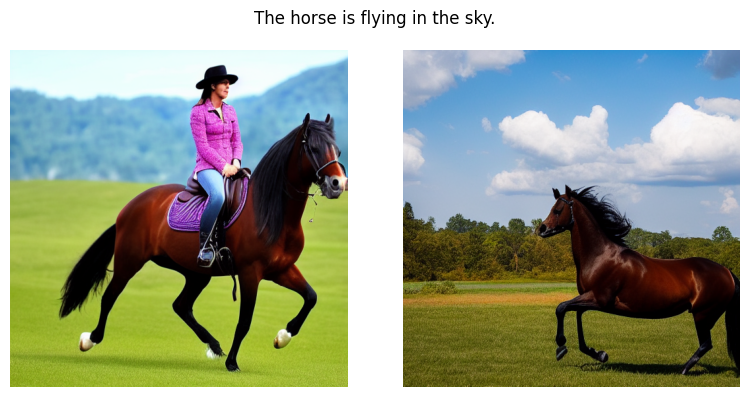

In [62]:
%matplotlib inline
with torch.inference_mode():
  feats, outputs = diffusion_extractor.forward(latents=latents, guidance_scale=guidance_scale)
  if feats is not None:
    """
    feats is the cached feature maps of shape (B, S, L, W, H) where
    B is the batch size
    S is the length of save_timestep
    L is the length of dims / the number of layers
    W, H is the dimension of the latent

    outputs is the x0 predictions (not xt) of length num_timesteps + 1 where
    the first element is the starting noise and the last is the final image
    """
    # reverse feats along the time dimension S
    # when passing to the aggregation network since it was trained
    # on feature maps from the inversion process (image to noise)
    # and we are running the generation process (noise to image)
    b, s, l, w, h = feats.shape
    diffusion_hyperfeats = aggregation_network(torch.flip(feats, dims=(1,)).float().view(b, -1, w, h))
synthetic_images = diffusion_extractor.latents_to_images(outputs[-1])

plt.clf()
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(synthetic_images[0])
axs[0].axis("off")
axs[1].imshow(synthetic_images[1])
axs[1].axis("off")
fig.suptitle(prompt)
fig.tight_layout()
plt.show()

**Interactively annotate semantic keypoint matches.**
- Setting 1: Set `show_dhf=False` and manually annotate the ground truth correspondences. Select a point on the left image then the semantically corresponding point on the right image. Repeat this for multiple point pairs. Re-run the cell to re-do the annotations. Finally, compare your annotations with the predicted semantic correspondences from Diffusion Hyperfeatures in the next section.
- Setting 2: Set `show_dhf=True` and click on the left image to immediately view the predicted semantic correspondences from Diffusion Hyperfeatures in the right image. 

In [10]:
# To interactively see what Diffusion Hyperfeatures predicts
# as the corresponding keypoint, simply set this flag to true
# and the prediction will appear as a green point on the right image.
# Your annotations will show up as red points in both images.
show_dhf = False

In [11]:
def get_corresponding_points(img1_feats, img2_feats, output_size, load_size):
  """
  Precompute nearest neighbor for every pixel in img1.
  To reduce memory usage, we do this computation in
  with descriptor maps of shape output_size and rescale to the load_size.
  """
  sims = batch_cosine_sim(img1_feats[None, ...], img2_feats[None, ...])
  num_pixels = int(math.sqrt(sims.shape[-1]))
  points1, points2 = find_nn_correspondences(sims)
  points1, points2 = points1[0].detach().cpu().numpy(), points2[0].detach().cpu().numpy()
  points1 = rescale_points(points1, output_size, load_size)
  points2 = rescale_points(points2, output_size, load_size)
  return points1, points2

# Set the load_size to 224 so that the PCK metric is comparable to prior work
# To view the predictions in full resolution, change load_size to (512, 512)
i, j = 0, 1
output_size = (config["output_resolution"], config["output_resolution"])
load_size = (224, 224)
img1, img2 = synthetic_images[i].resize(load_size), synthetic_images[j].resize(load_size)
points1_dhf, points2_dhf = get_corresponding_points(
  diffusion_hyperfeats[i],
  diffusion_hyperfeats[j],
  output_size,
  load_size
)

c:\Users\saqib\miniconda3\envs\pytorch_env\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


15

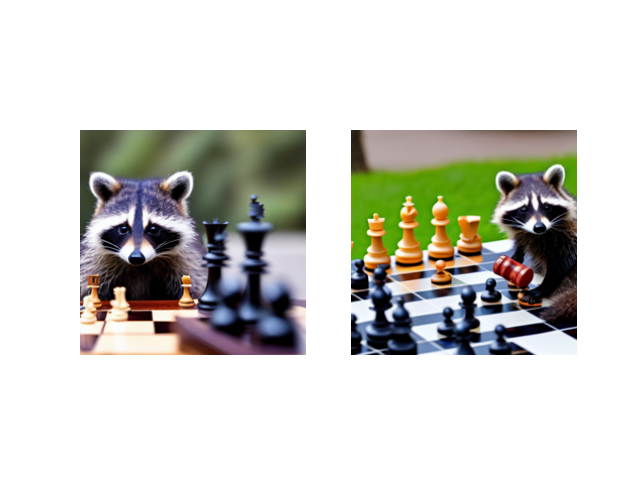

In [12]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

user_source_points, user_target_points = [], []
dhf_points = []

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img1)
axes[0].axis("off")
axes[1].imshow(img2)
axes[1].axis("off")
plt.draw()

def mouse_event(event):
  radius1, radius2 = 8, 1
  y, x = event.ydata, event.xdata
  
  if event.inaxes == axes[0]:
    color = "r"
    circ1_1 = plt.Circle((x, y), radius1, facecolor=color, edgecolor='white', alpha=0.5)
    circ1_2 = plt.Circle((x, y), radius2, facecolor=color, edgecolor='white')
    axes[0].add_patch(circ1_1)
    axes[0].add_patch(circ1_2)
    user_source_points.append((y, x))

    y_patch, x_patch = points_to_patches(np.array([[y, x]]), output_size[0], load_size)[0]
    idx = int(y_patch * output_size[0] + x_patch)

    # Diffusion Hyperfeatures
    y2, x2 = points2_dhf[idx]
    dhf_points.append((y2, x2))
    if show_dhf:
      color = "g"
      circ1_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
      circ1_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
      axes[1].add_patch(circ1_1)
      axes[1].add_patch(circ1_2)

  if event.inaxes == axes[1]:
    color = "r"
    circ1_1 = plt.Circle((x, y), radius1, facecolor=color, edgecolor='white', alpha=0.5)
    circ1_2 = plt.Circle((x, y), radius2, facecolor=color, edgecolor='white')
    axes[1].add_patch(circ1_1)
    axes[1].add_patch(circ1_2)
    user_target_points.append((y, x))

  fig.canvas.draw()

fig.canvas.mpl_connect('button_press_event', mouse_event)

**Display results.** Do not run this section if you are not running Setting 1, as it needs ground-truth annotations to compute the PCK for the predicted correspondences from Diffusion Hyperfeatures.

In [37]:
def log_predicted_points(title, prefix, predicted_points, user_source_points, user_target_points, load_size, img1, img2, df):
  distances, _, pck_metric = compute_pck(predicted_points, user_target_points, load_size)
  title = f"{title} \n PCK@0.1: {pck_metric.round(decimals=2)}"
  plt.clf()
  draw_correspondences(user_source_points, predicted_points, img1, img2, "", "", title=title, radius1=8, radius2=1)
  plt.show()
  df.update({
    f"{prefix}_points_y": predicted_points[:, 0],
    f"{prefix}_points_x": predicted_points[:, 1],
    f"{prefix}_distances": distances
  })
  return df

In [38]:
%matplotlib inline
if len(user_target_points) > 0 and len(user_source_points) == len(user_target_points):
  user_source_points, user_target_points = np.array(user_source_points), np.array(user_target_points)
  dhf_points = np.array(dhf_points)
  df = {
    "hash_name": [hash_name] * len(user_source_points),
    "user_source_points_y": user_source_points[:, 0],
    "user_source_points_x": user_source_points[:, 1],
    "user_target_points_y": user_target_points[:, 0],
    "user_target_points_x": user_target_points[:, 1]
  }

  # Log correspondence plots
  plt.clf()
  title = "User Annotations"
  draw_correspondences(user_source_points, user_target_points, img1, img2, "", "", title=title, radius1=8, radius2=1)
  plt.show()
  df = log_predicted_points("Diffusion Hyperfeatures", "dhf", dhf_points, user_source_points, user_target_points, load_size, img1, img2, df)

In [15]:
if len(user_target_points) > 0 and len(user_source_points) == len(user_target_points):
  # Log PCK distances
  df = pd.DataFrame(df)
  display(df)

  # Log images
  plt.clf()
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  axs[0].imshow(synthetic_images[0])
  axs[0].axis("off")
  axs[1].imshow(synthetic_images[1])
  axs[1].axis("off")
  fig.suptitle(prompt)
  fig.tight_layout()
  plt.show()

  # Save the noise used for this run
  if not os.path.exists("seeds"):
    os.mkdir("seeds")
  seeds = outputs[0]
  torch.save(seeds, f"seeds/{hash_name}.pt")

New Code

In [16]:
# Define a dictionary to store features
features = {}

# Hook function to store outputs
def get_features_hook(name):
    def hook(model, input, output):
        features[name] = output
    return hook

In [17]:
# Register hooks on specific layers
unet_model = diffusion_extractor.unet  # Assuming you have a UNet instance
print(unet_model)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [18]:
print(unet_model.down_blocks)


ModuleList(
  (0): CrossAttnDownBlock2D(
    (attentions): ModuleList(
      (0-1): 2 x Transformer2DModel(
        (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
        (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
        (transformer_blocks): ModuleList(
          (0): BasicTransformerBlock(
            (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
            (attn1): Attention(
              (to_q): Linear(in_features=320, out_features=320, bias=False)
              (to_k): Linear(in_features=320, out_features=320, bias=False)
              (to_v): Linear(in_features=320, out_features=320, bias=False)
              (to_out): ModuleList(
                (0): Linear(in_features=320, out_features=320, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
            (norm2): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
            (attn2): Attention(
              (to_q): Linear(in_features=320, out

In [36]:
unet_model.down_blocks[2].register_forward_hook(get_features_hook('down_block_2'))
unet_model.down_blocks[3].register_forward_hook(get_features_hook('down_block_3'))
unet_model.up_blocks[1].register_forward_hook(get_features_hook('up_block_1'))

In [70]:
# Run the diffusion process
guidance_scale = -1  # example value, adjust as needed
min_i = None
max_i = None

output = diffusion_extractor.run_generation(latents, guidance_scale=guidance_scale, min_i=min_i, max_i=max_i)


# Access the captured features
down_block_2_feats = features['down_block_2']
down_block_3_feats = features['down_block_3']
up_block_1_feats = features['up_block_1']

RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Half